## Neural Cellular Automata on PyTorch

This notebook is a "pytorch translation" of [this youtube video](https://www.youtube.com/watch?v=8EN_8p9Toyc) by Alexander Mordvintsev.

If you want to suggest any changes, feel free to make a PR :)

In [ ]:
!pip install torch-summary

In [3]:
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt 
import cv2 
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from IPython.display import Image, HTML, clear_output
from torchsummary import summary


In [1]:
# !wget -O flower.png https://raw.githubusercontent.com/googlefonts/noto-emoji/master/png/128/emoji_u1f33a.png
# !wget -O lizard.png https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/160/google/274/lizard_1f98e.png

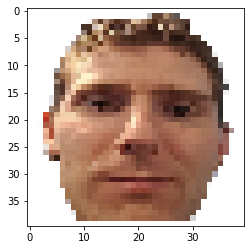

In [6]:
#@title {vertical-output: true}
width = 40
height = 40
filename = 'images/linus.png'
device = 'cuda'
im = (cv2.cvtColor(cv2.resize(cv2.imread(filename, cv2.IMREAD_UNCHANGED), (width,height)), cv2.COLOR_BGRA2RGBA)/255.0).astype(np.float32)
plt.imshow(im)
plt.show()

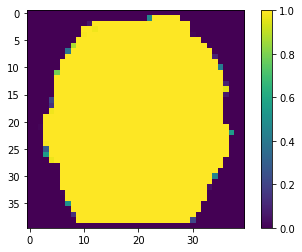

In [7]:
plt.imshow(im[:,:,3])  ## last channel 
plt.colorbar()

In [8]:
num_channels = 16
seed = np.zeros([1, width, height, num_channels], np.float32)
seed[:,width//2, height//2, 3:] = 1.0

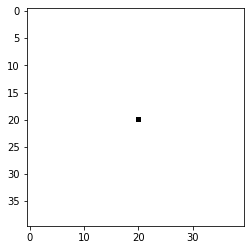

In [9]:
plt.imshow(seed[0,:,:,:4])
plt.show()

In [10]:
class ca_model(nn.Module):
    def __init__(self, checkpoint = None):
        super(ca_model, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size = 3,padding =1,  bias = True),  
            nn.ReLU(),
            nn.Conv2d(128, 16, kernel_size =  1, bias = True),
        )


        '''
        initial condition for "do nothing" behaviour:
            * all biases should be zero
            * the weights of the last layer should be zero
        '''
        self.model[0].bias.data.fill_(0)
        self.model[2].weight.data.fill_(0)
        self.model[2].bias.data.fill_(0)

        
    def forward(self, x):
        
        out = x + self.model(x)  ## reminds me of residual nets 
        return out

In [17]:
model = ca_model().to(device)
summary(model, (16,width,height))

In [ ]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

for i in range(100):
    x = model(x)

out = x[0].permute(-1, -2,0).cpu().detach().numpy()[:,:,:4]
plt.imshow(out)
plt.show()
out.mean(), out.min(), out.max()


In [12]:
def train_step(model, target, loss_func, iters, seed):
    x = seed 
    for i in range(iters):
        x =  model(x)
    loss = loss_func(x[:,:4, :,:], target)
    return loss, x


def to_rgb(img):
    rgb, a = img[:,:,:3], img[:,:,3:4]
    return 1.0-a+rgb

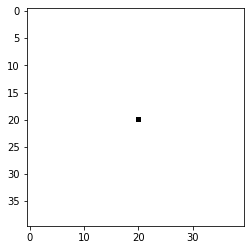

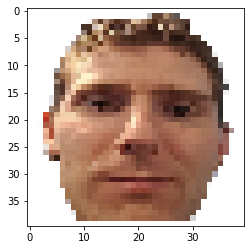

In [13]:
model = ca_model().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)


seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
target = torch.tensor(im.transpose(-1,0,1)).unsqueeze(0).to(device)

plt.imshow(seed_tensor[:,:4,:,:].cpu().permute(0,2,3,1).squeeze(0))
plt.show()

plt.imshow(target.cpu().permute(0,2,3,1).squeeze(0))
plt.show()

losses = []
samples = []



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


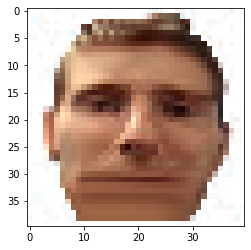

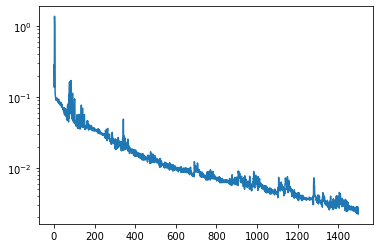

1499


In [14]:
epochs  = 1500
for i in tqdm(range(epochs)):


    loss, out = train_step(
        model = model, 
        target = target, 
        loss_func = F.mse_loss, 
        iters = 50,
        seed = seed_tensor
        )
    loss.backward()

    for p in model.parameters():
        '''
        gradient normalization for constant step size and to avoid spikes 
        '''
        p.grad.data = p.grad.data/(p.grad.data.norm()+1e-9)


    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())


    if i % 100 ==0 or i  == epochs-1:
        # samples.append(x[0].permute(-1, -2,0).cpu().detach().numpy()[:,:,:4])
        clear_output()
        samples.append(to_rgb(out[0].permute(-2, -1,0).cpu().detach().numpy()))
        plt.imshow(to_rgb(out[0].permute(-2, -1,0).cpu().detach().numpy()))
        plt.show()

        plt.plot(losses)
        # plt.plot(grads)
        plt.yscale('log')
        plt.show()

In [174]:
import os

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

class VideoWriter:
    def __init__(self, filename='_autoplay.mp4', fps=15.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1)*255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()
        if self.params['filename'] == '_autoplay.mp4':
            self.show()

    def show(self, **kw):
        self.close()
        fn = self.params['filename']
        display(mvp.ipython_display(fn, **kw))

In [ ]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

v = VideoWriter()
outs = []
with torch.no_grad():

    for i in range(50):
        x = model(x)
        v.add(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()))

for j in range(10):
    v.add(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()))
    
v.close()
v.show()